In [1]:
import pandas as pd

df = pd.read_csv('https://www.fdsp.net/data/covid-merged.csv')
df.set_index('state', inplace=True)
df['cases_norm'] = df['cases'] / df['population'] * 1000
df['gdp_norm'] = df['gdp'] / df['population'] * 1000;

In [2]:
first3 = df.loc[:'Arizona']
first3

,cases,population,gdp,urban,cases_norm,gdp_norm
state,,,,,,
Alabama,7068,4903185,230750.1,59.04,1.441512,47.061267
Alaska,353,731545,54674.7,66.02,0.482540,74.738670
Arizona,7648,7278717,379018.8,89.81,1.050735,52.072199


In [3]:
second3 = df.loc['Arkansas':'Colorado']
second3

,cases,population,gdp,urban,cases_norm,gdp_norm
state,,,,,,
Arkansas,3281,3017804,132596.4,56.16,1.087214,43.938042
California,50470,39512223,3205000.1,94.95,1.277326,81.114143
Colorado,15207,5758736,400863.4,86.15,2.640684,69.609616


In [4]:
first3['cases_norm'].mean()

np.float64(0.9915956672540028)

In [5]:
second3['cases_norm'].mean()

np.float64(1.6684081069437913)

In [6]:
diff = second3['cases_norm'].mean() - first3['cases_norm'].mean()
diff

np.float64(0.6768124396897884)

In [7]:
import numpy as np

pooled = np.hstack((first3['cases_norm'], second3['cases_norm']))
pooled

array([1.441512  , 0.48254038, 1.05073463, 1.08721441, 1.27732626,
       2.64068365])

In [8]:
import numpy.random as npr

npr.seed(21341)
npr.choice(pooled, 3)

array([1.05073463, 1.05073463, 2.64068365])

In [9]:
npr.seed(21398475)
print(npr.choice(pooled, 6))
print(npr.choice(pooled, 6, replace=False))

[1.27732626 0.48254038 1.05073463 1.27732626 1.27732626 0.48254038]
[1.05073463 1.27732626 1.08721441 0.48254038 1.441512   2.64068365]


In [10]:
first3_sample = npr.choice(pooled, len(first3))
second3_sample = npr.choice(pooled, len(second3))
print(f'new group first3_sample: {first3_sample}')
print(f'new group second3_sample: {second3_sample}')

print(f'original value of test statistic: {diff}')
print(f'sample value of test statistic: ', f'{second3_sample.mean() - first3_sample.mean()}')

new group first3_sample: [0.48254038 2.64068365 1.05073463]
new group second3_sample: [0.48254038 0.48254038 1.05073463]
original value of test statistic: 0.6768124396897884
sample value of test statistic:  -0.7193810910498654


In [11]:
# These are common to most simulation:
# 1) Set up the number of iterations (i.e., number of samples from the pool)
# 2) Initialize our counter to zero
num_sims = 10_000
count = 0
# Put these outside the loop to save execution time since they don't change
# Even though we know these, it is good to get in the habit of setting
# them dynamically from the data
first3_len = len(first3)
second3_len = len(second3)
for sim in range(num_sims):
    # Bootstrap sampling
    first3_sample = npr.choice(pooled, first3_len)
    second3_sample = npr.choice(pooled, second3_len)
    # Calculate the absolute value of the difference of means
    newdiff = abs(first3_sample.mean() - second3_sample.mean())
    # Update the counter if it exceeds the difference from the original groups
    if newdiff >= diff:
        count += 1
print('Prob. of seeing a result this extreme =~', count / num_sims)

Prob. of seeing a result this extreme =~ 0.2039


In [12]:
m_gdp = df['gdp_norm'].median()
m_gdp

np.float64(61.04737129841516)

In [13]:
higher_gdp = df[df['gdp_norm'] > m_gdp]
lower_gdp = df[df['gdp_norm'] <= m_gdp]
hgdp_mu = higher_gdp['cases_norm'].mean()
lgdp_mu = lower_gdp['cases_norm'].mean()

In [14]:
hgdp_mu, lgdp_mu

(np.float64(3.511241636831491), np.float64(1.9258062634390531))

In [15]:
diff_gdp = hgdp_mu - lgdp_mu
diff_gdp

np.float64(1.585435373392438)

In [16]:
pooled_covid = df['cases_norm']

In [17]:
# These are common to most simulation:
# 1) Set up the number of iterations (draws from the pool)
# 2) Initialize our counter to zero
num_sims = 10_000
count = 0
# Put these outside the loop to save execution time, since they don't change
higher_gdp_len = len(higher_gdp)
lower_gdp_len = len(lower_gdp)
for sim in range(num_sims):
    # Bootstrap sampling
    higher_gdp_sample = npr.choice(pooled_covid, higher_gdp_len)
    lower_gdp_sample = npr.choice(pooled_covid, lower_gdp_len)
    # Calculate the absolute value of the difference of means
    newdiff = abs(higher_gdp_sample.mean() - lower_gdp_sample.mean())
    # Update the counter if it exceeds the difference from the original groups
    if newdiff >= diff_gdp:
        count += 1
print(f'Prob. of seeing a result this extreme =~ {count / num_sims: .3f}')

Prob. of seeing a result this extreme =~  0.075


In [18]:
def resample_mean(pooled_data, diff, len1, len2, num_sims=10_000):
    """Resample from pooled data and conduct a two-tailed NHST
    on the mean-difference
    Inputs
    ------
    pooled_data: NumPy array of all data in the original 2 groups
    diff: observed difference in sample means in the original groups
    len1, len2: the lengths of the original groups
    num_sims: the number of simulation iterations
    Output
    ------
    prints resulting p-value
    """
    count = 0
    for sim in range(num_sims):
        # Bootstrap sampling
        group1 = npr.choice(pooled_data, len1)
        group2 = npr.choice(pooled_data, len2)
        # Calculate the absolute value of the difference of means
        newdiff = abs(group1.mean() - group2.mean())
        # Update the counter if observed difference as large as original
        if newdiff >= diff:
            count += 1
    print(f'Prob. of seeing a result this extreme =~ {count / num_sims}')

In [19]:
resample_mean(pooled_covid, diff_gdp, len(higher_gdp), len(lower_gdp))

Prob. of seeing a result this extreme =~ 0.0705


In [20]:
m_urban = df["urban"].median()
higher_urban = df[df["urban"] > m_urban]
lower_urban = df[df["urban"] <= m_urban]

In [21]:
higher_urban["cases_norm"].mean(), lower_urban["cases_norm"].mean()

(np.float64(3.8908749904320756), np.float64(1.5461729098384682))

In [22]:
diff_urban = higher_urban["cases_norm"].mean() - lower_urban["cases_norm"].mean()
diff_urban

np.float64(2.344702080593607)

In [23]:
resample_mean(pooled_covid, diff_urban, len(higher_urban), len(lower_urban))

Prob. of seeing a result this extreme =~ 0.01


In [24]:
import matplotlib.pyplot as plt


def resample_mean_hist(pooled_data, diff, len1, len2, num_sims=10_000):
    '''(Docstring omitted to conserve space)'''
    count = 0
    sample_means = []  # New variable to store sample means
    for sim in range(num_sims):
        # Bootstrap sampling
        group1 = npr.choice(pooled_data, len1)
        group2 = npr.choice(pooled_data, len2)
        # Calculate the absolute value of the difference of means
        newdiff = abs(group1.mean() - group2.mean())
        sample_means += [group1.mean() - group2.mean()]  # Store sample mean
        # Update the counter if it exceeds the difference from the original groups
        if newdiff >= diff:
            count += 1
    print(f'Prob. of seeing a result this extreme =~ {count / num_sims}')
    plt.hist(sample_means, 40)  # Plot the histogram with 40 bins

Prob. of seeing a result this extreme =~ 0.0085


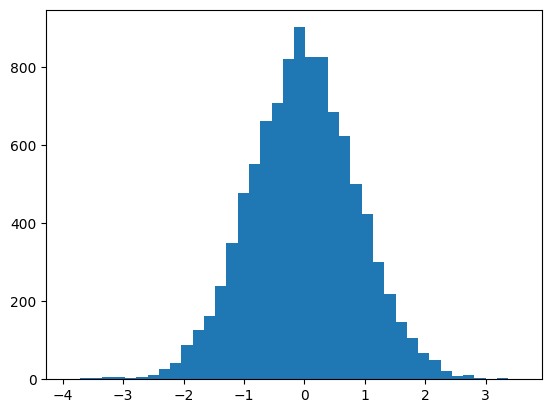

In [25]:
resample_mean_hist(pooled_covid, diff_urban, len(higher_urban), len(lower_urban))